# Objetivo da análise

O objetivo deste projeto é analisar o perfil dos assinantes de realizam do canal educativo Teo Me Why na Twitch e treinar um modelo de machine learning que estime a probabilidade de churn dos inscritos.

##Preparando o ambiente


In [0]:
!pip install scikit-learn
!pip install matplotlib scikit-learn graphviz
!pip install plotly
!pip install factor_analyzer
!pip install pandas

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.7 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use up

In [0]:
import numpy as np
import seaborn as sns
from matplotlib  import pyplot as plt
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition  import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import IterativeImputer
import plotly.graph_objects as go
import pandas as pd

# setando gráficos para aparecerem no jupyter notebook
%matplotlib inline

#Análise inicial dos dados

In [0]:
# Importando a tabela que o Teo criou e transformando em um dataframe
#df = spark.table("feature_store.med.abt_churn").toPandas()
df = spark.table("sandbox.med.Teo_abt_churn").toPandas()


In [0]:
df.head(5)

,dtRef,idCliente,flChurn,nrSomaPontos,nrSomaPontosPos,nrSomaPontosNeg,nrTicketMedio,nrTicketMedioPos,nrTicketMedioNeg,nrPontosDia,nrQtdeTransacoes,nrQtdeDias,nrRecenciaDias,nrQtdeTransacaoDay2,nrQtdeTransacaoDay3,nrQtdeTransacaoDay4,nrQtdeTransacaoDay5,nrQtdeTransacaoDay6,nrQtdeDay2,nrQtdeDay3,nrQtdeDay4,nrQtdeDay5,nrQtdeDay6,nrAvgRecorrencia
0,2024-06-01,000ff655-fa9f-4baa-a108-47f581ec52a1,1,151,151,0,37.750000,37.750000,0.0,50.333333,4,3,1,0,1,2,0,1,0,1,1,0,1,12.0
1,2024-08-01,001749bd-37b5-4b1e-8111-f9fbba90f530,1,50,50,0,50.000000,50.000000,0.0,50.000000,1,1,21,0,0,0,1,0,0,0,0,1,0,NaN
2,2024-07-01,0019bb9e-26d4-4ebf-8727-fc911ea28a92,1,1,1,0,1.000000,1.000000,0.0,1.000000,1,1,25,0,0,0,1,0,0,0,0,1,0,NaN
3,2024-02-01,0097ab76-4637-4ece-8ebc-ab6abd61d662,0,52,52,0,17.333333,17.333333,0.0,52.000000,3,1,1,0,0,3,0,0,0,0,1,0,0,NaN
4,2024-08-01,00a6d4c8-38e5-4e92-981e-4e4ac5084546,0,1312,3312,-2000,36.444444,97.411765,-1000.0,93.714286,35,14,2,7,10,6,5,8,3,3,2,3,3,2.0


In [0]:
df.isnull().sum()

dtRef                    0
idCliente                0
flChurn                  0
nrSomaPontos             0
nrSomaPontosPos          0
nrSomaPontosNeg          0
nrTicketMedio            0
nrTicketMedioPos         0
nrTicketMedioNeg         0
nrPontosDia              0
nrQtdeTransacoes         0
nrQtdeDias               0
nrRecenciaDias           0
nrQtdeTransacaoDay2      0
nrQtdeTransacaoDay3      0
nrQtdeTransacaoDay4      0
nrQtdeTransacaoDay5      0
nrQtdeTransacaoDay6      0
nrQtdeDay2               0
nrQtdeDay3               0
nrQtdeDay4               0
nrQtdeDay5               0
nrQtdeDay6               0
nrAvgRecorrencia       706
dtype: int64

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1540 entries, 0 to 1539
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dtRef                1540 non-null   object 
 1   idCliente            1540 non-null   object 
 2   flChurn              1540 non-null   int32  
 3   nrSomaPontos         1540 non-null   int64  
 4   nrSomaPontosPos      1540 non-null   int64  
 5   nrSomaPontosNeg      1540 non-null   int64  
 6   nrTicketMedio        1540 non-null   float64
 7   nrTicketMedioPos     1540 non-null   float64
 8   nrTicketMedioNeg     1540 non-null   float64
 9   nrPontosDia          1540 non-null   float64
 10  nrQtdeTransacoes     1540 non-null   int64  
 11  nrQtdeDias           1540 non-null   int64  
 12  nrRecenciaDias       1540 non-null   int32  
 13  nrQtdeTransacaoDay2  1540 non-null   int64  
 14  nrQtdeTransacaoDay3  1540 non-null   int64  
 15  nrQtdeTransacaoDay4  1540 non-null   i

Text(0.5, 1.0, 'Número de contas ativas e inativas entre fevereiro e agosto de 2024')

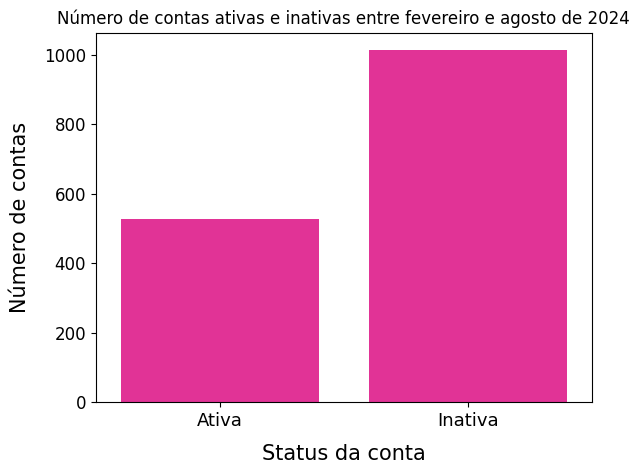

In [0]:
ax = sns.barplot(x=df['flChurn'].unique(), y=df['flChurn'].value_counts(dropna=False), data=df, color = '#fe169a') 
plt.ylabel("Número de contas", labelpad=10, fontsize = 15)
plt.xlabel("Status da conta", labelpad=10, fontsize = 15)
plt.yticks(fontsize = 12)
ax.set_xticklabels(["Ativa", "Inativa"], fontsize=13)
ax.set_title('Número de contas ativas e inativas entre fevereiro e agosto de 2024')

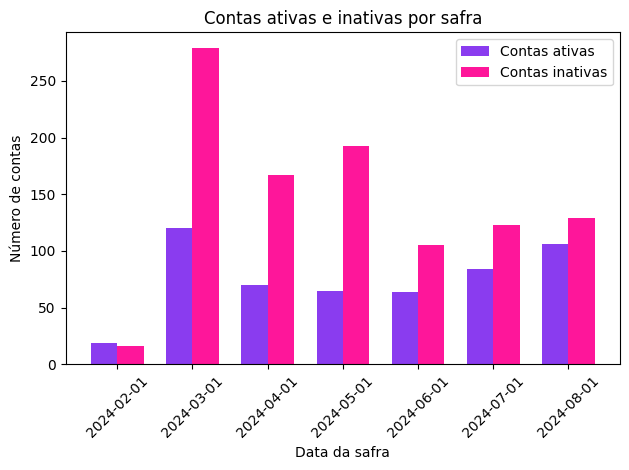

In [0]:
# Convertendo a coluna dtRef para o tipo correto
df['dtRef'] = pd.to_datetime(df['dtRef'])

# Agrupando os dados por dtRef e flChurn e contando o número de idCliente
df_grouped = df.groupby([df['dtRef'].dt.strftime('%Y-%m-%d'), 'flChurn'])['idCliente'].count().unstack(fill_value=0).reset_index()

# Renomeando as colunas para melhor entendimento
df_grouped.columns = ['dtRef', 'Ativa', 'Inativa']

# Configurando o eixo X para ter as posições dos meses
x = np.arange(len(df_grouped['dtRef']))

# Largura das barras
largura = 0.35

# Criando o gráfico de barras duplas
fig, ax = plt.subplots()

# Barras para contas ativas
barras_ativas = ax.bar(x - largura/2, df_grouped['Ativa'], largura, label='Contas ativas', color='#8a3cef')

# Barras para contas desistentes
barras_desistentes = ax.bar(x + largura/2, df_grouped['Inativa'], largura, label='Contas inativas', color='#fe169a')

# Adicionando rótulos e título
ax.set_xlabel('Data da safra')
ax.set_ylabel('Número de contas')
ax.set_title('Contas ativas e inativas por safra')
ax.set_xticks(x)
ax.set_xticklabels(df_grouped['dtRef'], rotation=45)
ax.legend()

# Mostrando o gráfico
plt.tight_layout()
plt.show()

A diferença entre o número de contas ativas e inativas em cada janela de observação diminui a cada safra (mês).

/home/spark-5a9e4130-8e76-478c-b09a-01/.ipykernel/2185/command-1807406999630052-2905109176:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dias_semana, fontsize=13)


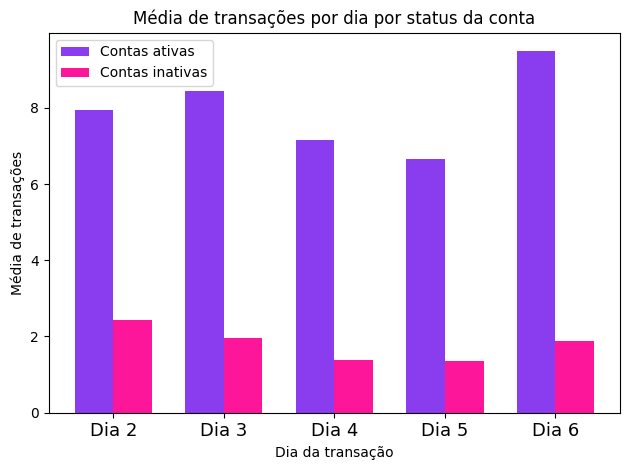

In [0]:
# Calculando a média das transações por dia agrupadas por flChurn
import numpy as np

df_mean_transacoes = df.groupby('flChurn')[['nrQtdeTransacaoDay2', 'nrQtdeTransacaoDay3', 'nrQtdeTransacaoDay4', 'nrQtdeTransacaoDay5', 'nrQtdeTransacaoDay6']].mean().transpose()

# Configurando o eixo X com os dias
x = np.arange(len(df_mean_transacoes.index))

# Largura das barras
largura = 0.35

# Criando o gráfico de barras
fig, ax = plt.subplots()

# Barras para a média de transações por dia para contas ativas
barras_transacoes_ativas = ax.bar(x - largura/2, df_mean_transacoes[0].values, largura, label='Contas ativas', color='#8a3cef')

# Barras para a média de transações por dia para contas inativas
barras_transacoes_inativas = ax.bar(x + largura/2, df_mean_transacoes[1].values, largura, label='Contas inativas', color='#fe169a')

# Substituindo os rótulos dos dias no eixo X
dias_semana = ['Dia 2', 'Dia 3', 'Dia 4', 'Dia 5', 'Dia 6']
ax.set_xticklabels(dias_semana, fontsize=13)

# Adicionando rótulos e título
ax.set_xlabel('Dia da transação')
ax.set_ylabel('Média de transações')
ax.set_title('Média de transações por dia por status da conta')
ax.set_xticks(x)
ax.legend()

# Mostrando o gráfico
plt.tight_layout()
plt.show()



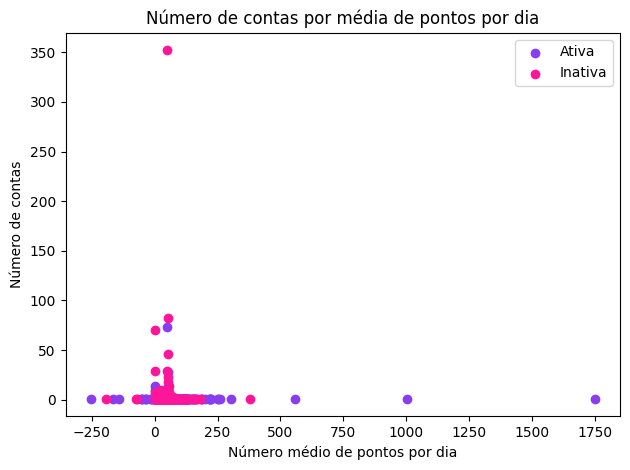

In [0]:
import matplotlib.pyplot as plt

# Calculating the count of nrPontosDia grouped by flChurn
df_count = df.groupby(['nrPontosDia', 'flChurn']).size().reset_index(name='count')

# Creating the scatter plot for each churn category with updated labels and colors
for churn_status, group in df_count.groupby('flChurn'):
    if churn_status == 1:
        label = 'Inativa'
        color = '#fe169a'
    else:
        label = 'Ativa'
        color = '#8a3cef'
    plt.scatter(group['nrPontosDia'], group['count'], label=label, color=color)

# Adding labels and title
plt.xlabel('Número médio de pontos por dia')
plt.ylabel('Número de contas')
plt.title('Número de contas por média de pontos por dia')
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.show()

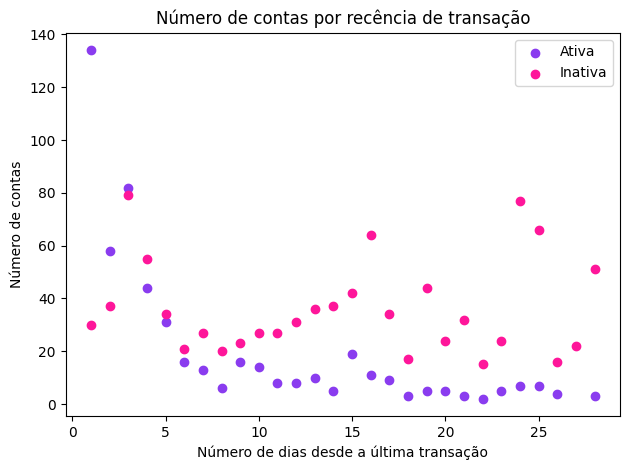

In [0]:
import matplotlib.pyplot as plt

# Calculating the count of nrRecenciaDias grouped by flChurn
df_count = df.groupby(['nrRecenciaDias', 'flChurn']).size().reset_index(name='count')

# Creating the scatter plot for each churn category with updated labels and colors
for churn_status, group in df_count.groupby('flChurn'):
    if churn_status == 1:
        label = 'Inativa'
        color = '#fe169a'
    else:
        label = 'Ativa'
        color = '#8a3cef'
    plt.scatter(group['nrRecenciaDias'], group['count'], label=label, color=color)

# Adding labels and title
plt.xlabel('Número de dias desde a última transação')
plt.ylabel('Número de contas')
plt.title('Número de contas por recência de transação')
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.show()

In [0]:
grouped = df.groupby('flChurn')[['nrTicketMedioPos', 'nrTicketMedioNeg', 'nrSomaPontosPos', 'nrSomaPontosNeg']].mean()
result = grouped.transpose()
print(result)

flChurn                    0           1
nrTicketMedioPos   24.343433   26.411835
nrTicketMedioNeg  -86.608578   -3.764822
nrSomaPontosPos   488.429924  104.489130
nrSomaPontosNeg  -180.018939   -7.559289


O número de pontos positivos por transação (nrTicketMedioPos) é similar entre contas ativas e inativas (0 e 1, respectivamente). Entretanto, observa-se que o ticket médio negativo é muito menor para contas inativas.
Nas contas ativas, a média do número total de pontos negativos é cerca de 2,71 vezes maior que a média do número total de pontos positivos.
Já nas contas inativas, essa diferença é de cerca de 13,75.


# Analytical Base Table (ABT)

In [0]:
df = df.drop(columns=['nrSomaPontos', 'nrTicketMedio','nrQtdeTransacoes'])

Podemos remover variáveis com baixa variabilidade, uma vez que elas não contribuem significativamente para a análise.

In [0]:
df.var() # Calculando a variância

/home/spark-5a9e4130-8e76-478c-b09a-01/.ipykernel/2185/command-428473906446192-4093858002:1: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.var() # Calculando a variância


flChurn                     0.225453
nrSomaPontosPos        246445.525381
nrSomaPontosNeg        153870.117212
nrTicketMedioPos          556.127931
nrTicketMedioNeg        28479.646656
nrPontosDia              3799.625247
nrQtdeDias                 13.990726
nrRecenciaDias             76.840374
nrQtdeTransacaoDay2       209.486378
nrQtdeTransacaoDay3       234.904966
nrQtdeTransacaoDay4       151.912088
nrQtdeTransacaoDay5       138.474838
nrQtdeTransacaoDay6       310.590643
nrQtdeDay2                  0.820361
nrQtdeDay3                  0.849738
nrQtdeDay4                  0.777995
nrQtdeDay5                  0.781963
nrQtdeDay6                  0.770537
nrAvgRecorrencia           12.710083
dtype: float64

In [0]:
# Remover colunas com variância muito baixa
df = df.drop(columns=['nrQtdeDay2', 'nrQtdeDay3', 'nrQtdeDay4', 'nrQtdeDay5', 'nrQtdeDay6'])

In [0]:
df = df.drop(columns=['nrAvgRecorrencia'])

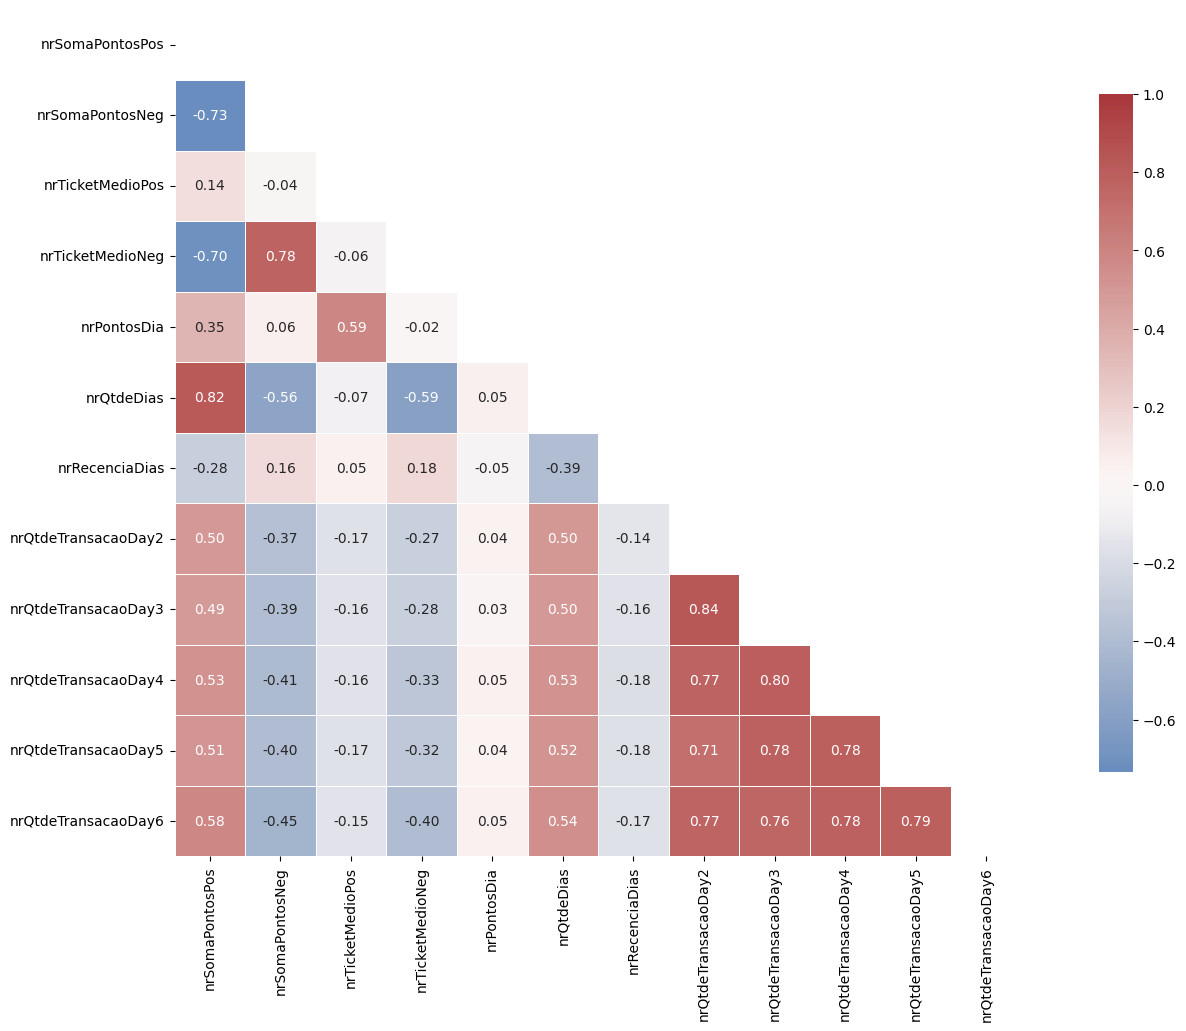

In [0]:
df_num = df.drop(columns=['dtRef','idCliente','flChurn']) # Separando somente as variáveis quantitativas do banco de dados
corr = df_num.corr() # Criando a matriz de correlação    
mask = np.triu(np.ones_like(corr, dtype=bool)) # Criando uma máscara que indica os valores correlacionados
f, ax = plt.subplots(figsize=(20, 11))          # Criando uma figura para plotar os valores
cmap = sns.diverging_palette(230, 20, as_cmap=True) # Definindo a paleta de cores
sns.heatmap (corr, mask=mask, cmap='vlag', vmax=1, center=0, # Plotando a matriz de correlação
             square=True, linewidth=.5, cbar_kws={'shrink':.8}, annot=True, fmt= ".2f")
plt.show()



A quantidade de transações em um dia da semana está positivamente correlacionada com a quantidade de transações em qualquer outro dia da semana.
Isto indica quanto maior o número de transações em um dia, maior o número de transações em qualquer outro dia da semana.

In [0]:
df.head()

,dtRef,idCliente,flChurn,nrSomaPontosPos,nrSomaPontosNeg,nrTicketMedioPos,nrTicketMedioNeg,nrPontosDia,nrQtdeDias,nrRecenciaDias,nrQtdeTransacaoDay2,nrQtdeTransacaoDay3,nrQtdeTransacaoDay4,nrQtdeTransacaoDay5,nrQtdeTransacaoDay6
0,2024-06-01,000ff655-fa9f-4baa-a108-47f581ec52a1,1,151,0,37.750000,0.0,50.333333,3,1,0,1,2,0,1
1,2024-08-01,001749bd-37b5-4b1e-8111-f9fbba90f530,1,50,0,50.000000,0.0,50.000000,1,21,0,0,0,1,0
2,2024-07-01,0019bb9e-26d4-4ebf-8727-fc911ea28a92,1,1,0,1.000000,0.0,1.000000,1,25,0,0,0,1,0
3,2024-02-01,0097ab76-4637-4ece-8ebc-ab6abd61d662,0,52,0,17.333333,0.0,52.000000,1,1,0,0,3,0,0
4,2024-08-01,00a6d4c8-38e5-4e92-981e-4e4ac5084546,0,3312,-2000,97.411765,-1000.0,93.714286,14,2,7,10,6,5,8


# Árvore de Decisão 

In [0]:
target = 'flChurn' 
features = df.columns.tolist()[3:]
X = df[features]
y = df[target]

In [0]:
# Separando Treino e teste (80/20)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=43)
print("Taxa resposta treino:", y_train.mean())
print("Taxa resposta test:", y_test.mean())


Taxa resposta treino: 0.6550324675324676
Taxa resposta test: 0.6655844155844156


Treinando e validando o modelo com profundidade 10

In [0]:
# Criando um objeto imputer com IterativeImputer
imputer = IterativeImputer(max_iter=10, random_state=4)

# Ajustar o imputer aos dados de treinamento e transformá-los para preencher valores NaN
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_test)  # Transformar dados de validação usando o mesmo imputer

# Listas para armazenar as acurácias
train_scores = []
val_scores = []

# Laço para treinar o modelo e registrar os resultados
values = range(1, 11)

for i in values:
    model = DecisionTreeClassifier(max_depth=10, random_state=4)  # Ajustando a profundidade da árvore para i
    model.fit(X_train_imputed, y_train)  # Treinar o modelo com dados imputados

    yhat_train = model.predict(X_train_imputed)  # Fazendo previsões com dados de treino
    acc_train = accuracy_score(y_train, yhat_train)  # Avaliando a acurácia do modelo
    train_scores.append(acc_train)  # Armazenando a acurácia do modelo na lista 

    yhat_val = model.predict(X_val_imputed)  # Fazendo previsões com dados de validação
    acc_val = accuracy_score(y_test, yhat_val)  # Avaliando a acurácia do modelo com dados de validação
    val_scores.append(acc_val)  # Armazenando a acurácia do modelo na lista

print(f"Acurácia no conjunto de treino: {acc_train:.2f}")
print(f"Acurácia no conjunto de validação: {acc_val:.2f}")

/databricks/python/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but IterativeImputer was fitted without feature names
  warnings.warn(


Acurácia no conjunto de treino: 0.92
Acurácia no conjunto de validação: 0.75


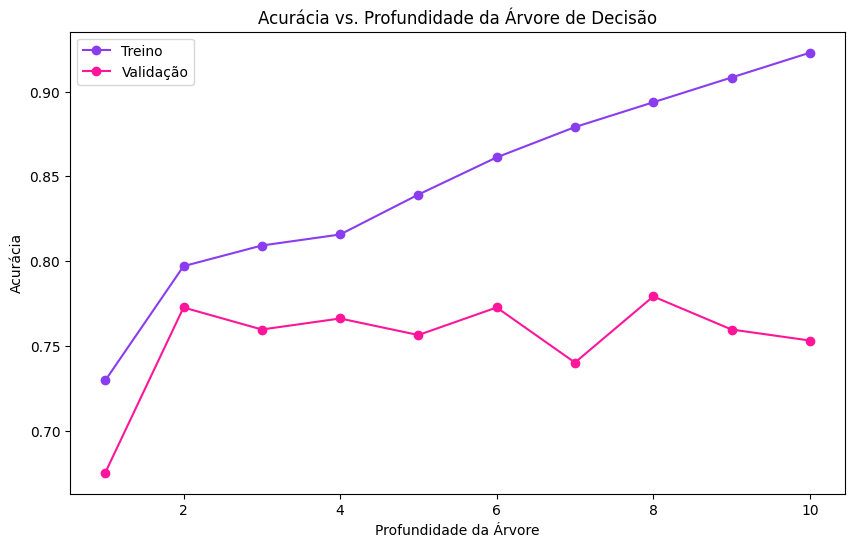

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(values, train_scores, '-o', label="Treino", color='#8a3cef')
plt.plot(values, val_scores, '-o', label="Validação", color='#fe169a')
plt.xlabel('Profundidade da Árvore')
plt.ylabel('Acurácia')
plt.title('Acurácia vs. Profundidade da Árvore de Decisão')
plt.legend()
plt.show()

# Random Forest

In [0]:
# Criando um objeto imputer com IterativeImputer
imputer_forest = IterativeImputer(max_iter=10, random_state=4)

# Ajustar o imputer aos dados de treinamento e transformá-los para preencher valores NaN
X_train_imputed = imputer_forest.fit_transform(X_train)
X_val_imputed = imputer_forest.transform(X_test)  # Transformar dados de validação usando o mesmo imputer

# Criando o modelo RandomForestClassifier com 100 estimadores
n_estimators_values = [100]  
train_scores = []
val_scores = []

# Criando o modelo RandomForestClassifier com 100 estimadores
for n_estimators in n_estimators_values:
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=4)
    model.fit(X_train_imputed, y_train)  # Treinar o modelo com dados imputados

    yhat_train = model.predict(X_train_imputed)  # Fazendo previsões com dados de treino
    yhat_val = model.predict(X_val_imputed)  # Fazendo previsões com dados de validação

# Avaliando a acurácia do modelo
acc_train = accuracy_score(y_train, yhat_train)
acc_val = accuracy_score(y_test, yhat_val)
# Adicionando as acurácias às listas
train_scores.append(acc_train)
val_scores.append(acc_val)

# Exibir os resultados
print(f"Acurácia no conjunto de treino: {acc_train:.2f}")
print(f"Acurácia no conjunto de validação: {acc_val:.2f}")

/databricks/python/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but IterativeImputer was fitted without feature names
  warnings.warn(


Acurácia no conjunto de treino: 0.96
Acurácia no conjunto de validação: 0.72


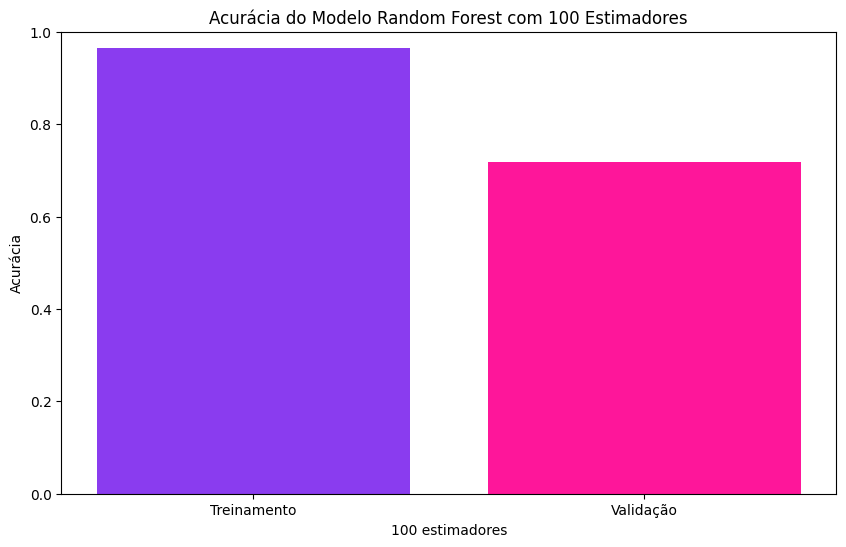

In [0]:
#plotando o gráfico (Dado que o código está configurado para avaliar um modelo com um número fixo de estimadores (n_estimators=100), o melhor gráfico para mostrar a acurácia do modelo seria um gráfico de barras)
labels = ['Treinamento', 'Validação']
accuracies = [acc_train, acc_val]

plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies, color=['#8a3cef', '#fe169a'])
plt.xlabel('100 estimadores')
plt.ylabel('Acurácia')
plt.title('Acurácia do Modelo Random Forest com 100 Estimadores')
plt.ylim(0, 1)  # Limitar o eixo y para 0 a 1 para facilitar a comparação
plt.show()

##Outras métricas para a random forest

In [0]:
# matriz de confusão para treino e validação
conf_matrix_train = confusion_matrix(y_train, yhat_train)
conf_matrix_val = confusion_matrix(y_test, yhat_val)

print("Matriz de Confusão - Treinamento:")
print(conf_matrix_train)
print("Matriz de Confusão - Validação:")
print(conf_matrix_val)

Matriz de Confusão - Treinamento:
[[392  33]
 [ 11 796]]
Matriz de Confusão - Validação:
[[ 48  55]
 [ 32 173]]


A matriz de confusão é uma ferramenta que avalia o desempenho de um modelo de classificação, mostrando a quantidade de previsões corretas e incorretas para cada classe. Ela detalha os verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos, permitindo entender como o modelo está se comportando em relação a cada classe. É útil para identificar onde o modelo está acertando e onde está errando.

_Treinamento_:
  - Verdadeiros Positivos (TP): 796
  - Falsos Positivos (FP): 33
  - Falsos Negativos (FN): 11
  - Verdadeiros Negativos (TN): 392

O modelo tem uma alta taxa de verdadeiros positivos e baixos falsos positivos e negativos, indicando boa performance no treinamento.

_Validação_:
  - TP: 173
  - FP: 55
  - FN: 32
  - TN: 48


No conjunto de validação, há um aumento significativo nos falsos positivos e falsos negativos. Isso sugere que o modelo tem dificuldade em generalizar para novos dados, o que pode ser um problema de overfitting.


In [0]:
# precisão para treino e validação
from sklearn.metrics import precision_score

precision_train = precision_score(y_train, yhat_train)
precision_val = precision_score(y_test, yhat_val)

print(f"Precisão no conjunto de treino: {precision_train:.2f}")
print(f"Precisão no conjunto de validação: {precision_val:.2f}")

Precisão no conjunto de treino: 0.96
Precisão no conjunto de validação: 0.76


 Indica o quão confiável é o modelo quando ele prevê que um evento ocorrerá. Uma alta precisão significa que a maioria das previsões positivas do modelo é correta.
 
_Precisão no Conjunto de Treino: 0.96_: 
 alta precisão no treinamento indica que quando o modelo prevê churn, ele é geralmente correto.

_Precisão no Conjunto de Validação: 0.76_: a precisão no conjunto de validação é menor, mas ainda razoável. Isso mostra que o modelo é mais propenso a erros ao prever churn em novos dados.


In [0]:
from sklearn.metrics import recall_score

#recall para treino e validação
recall_train = recall_score(y_train, yhat_train)
recall_val = recall_score(y_test, yhat_val)

print(f"Recall no conjunto de treino: {recall_train:.2f}")
print(f"Recall no conjunto de validação: {recall_val:.2f}")

Recall no conjunto de treino: 0.99
Recall no conjunto de validação: 0.84


Mede a capacidade do modelo de detectar todos os casos positivos existentes.

_Recall no Conjunto de Treino: 0.99_: muito alto, indicando que o modelo identifica quase todos os casos de churn no treinamento.

_Recall no Conjunto de Validação: 0.84_:
o recall é menor no conjunto de validação, mas ainda bom. Isso indica que o modelo está perdendo alguns casos de churn ao generalizar para novos dados, mas ainda é relativamente eficaz em detectar churn.


In [0]:
from sklearn.metrics import f1_score

# F1-score para treino e validação
f1_train = f1_score(y_train, yhat_train)
f1_val = f1_score(y_test, yhat_val)

print(f"F1-Score no conjunto de treino: {f1_train:.2f}")
print(f"F1-Score no conjunto de validação: {f1_val:.2f}")

F1-Score no conjunto de treino: 0.97
F1-Score no conjunto de validação: 0.80


Avalia o equilíbrio entre a capacidade do modelo de identificar corretamente os eventos positivos e minimizar falsos positivos e negativos. 

_F1-Score no Conjunto de Treino: 0.97_: indica um bom equilíbrio entre precisão e recall.

_F1-Score no Conjunto de Validação: 0.80_: é menor no conjunto de validação, refletindo o impacto do desbalanceamento entre precisão e recall na capacidade de prever churn.


In [0]:
from sklearn.metrics import roc_curve, auc

# Obter probabilidades de churn
y_proba_train = model.predict_proba(X_train_imputed)[:, 1]
y_proba_val = model.predict_proba(X_val_imputed)[:, 1]

# Calcular a curva ROC e AUC
fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
fpr_val, tpr_val, _ = roc_curve(y_test, y_proba_val)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_val = auc(fpr_val, tpr_val)

print(f"AUC no conjunto de treino: {roc_auc_train:.2f}")
print(f"AUC no conjunto de validação: {roc_auc_val:.2f}")


AUC no conjunto de treino: 0.99
AUC no conjunto de validação: 0.77


A curva ROC (Receiver Operating Characteristic) ilustra a capacidade do modelo de distinguir entre as classes positivas e negativas ao variar o limiar de decisão. A AUC (Área sob a Curva) quantifica essa capacidade, representando a área total sob a curva ROC. Um valor de AUC próximo de 1 indica um excelente desempenho na separação das classes (churn e não-churn).

_AUC no Conjunto de Treino: 0.99_

_AUC no Conjunto de Validação: 0.77_
 
 No treinamento, a AUC alta indica que o modelo tem excelente capacidade de discriminar entre churn e não-churn. No entanto, a AUC no conjunto de validação é menor, sugerindo que a discriminação entre classes não é tão eficaz em novos dados.

In [0]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calcular curva Precision-Recall e AUC-PR
precision_train, recall_train, _ = precision_recall_curve(y_train, y_proba_train)
precision_val, recall_val, _ = precision_recall_curve(y_test, y_proba_val)

auc_pr_train = average_precision_score(y_train, y_proba_train)
auc_pr_val = average_precision_score(y_test, y_proba_val)

print(f"AUC-PR no conjunto de treino: {auc_pr_train:.2f}")
print(f"AUC-PR no conjunto de validação: {auc_pr_val:.2f}")


AUC-PR no conjunto de treino: 0.99
AUC-PR no conjunto de validação: 0.85


A curva Precision-Recall (PR) mostra a relação entre precisão e recall em diferentes limiares de decisão do modelo. A AUC-PR (Área sob a Curva Precision-Recall) quantifica a eficácia do modelo na identificação de casos positivos, especialmente em situações com desbalanceamento de classes.

_AUC-PR no Conjunto de Treino: 0.99_

_AUC-PR no Conjunto de Validação: 0.85_

Alta AUC-PR tanto no treinamento quanto na validação indica que o modelo é bastante eficaz na identificação da classe minoritária (churn), mesmo quando há desbalanceamento de classes.


##Conclusão
O modelo Random Forest foi testado para prever quais assinantes vão churnar. Ele teve um ótimo desempenho nos dados usados para treinar o modelo, com 96% de acurácia. No entanto, quando aplicamos o modelo a novos dados, a acurácia caiu para 72%, o que sugere que o modelo pode estar com overfit e não se sair tão bem em situações novas. A precisão e o recall também foram muito bons no treinamento, mas diminuíram na validação. 
De forma geral, vemos que o modelo identifica bem os assinantes que churnarão, mas precisa de ajustes para melhorar sua performance em dados que ainda não viu.